# [LINMA1702] Analyse d'un modèle raffiné avec stockage et gaz.
##### <center> *Ansotte Justin | Belpaire Victor | Charles Benjamin*


# Introduction

La deuxième partie de ce projet a pour objectif d'examiner une série de modèles plus réalistes qui prendront en compte pour le premier, la demande en énergie éléctrique, les coûts d'installations et les capacités de stockage hydroéléctrique. Ensuite pour le deuxième modèle, on rajoutera la possibilité d'installer des centrales au gaz.


## Situation II.1
##  Formulation du problème sous la forme d'un modèle d'optimisation linéaire :


**Variables:**

- $x$ est le vecteur contenant les puissances éoliennes installées sur chaque site (MW)
- $B$ est le vecteur contenant les énergies hydroélectriques stockées à chaque période de T heures (MWh)
- $H_m$ est le vecteur contenant les ajouts d'énergie hydroélectrique venant de l'éolien à chaque période (MWh)
- $H_d$ est le vecteur contenant les énergies qui vont de l'hydroélectrique vers la consommation à chaque période (MWh)
- $E$ est le vecteur contenant l'énergie qui est directement consommée par les habitants venant de l'éolien à chaque période (MWh)

**Objectif:**
$$\min_{x, B, H_m, H_d, P} c_{onshore} \sum_{i \in O} x_i + c_{offshore} \sum_{i \in F} x_i$$

où
- $c_{onshore}$ est le coût amorti sur un an pour l'installation d'un MW éolien onshore (euros/MW/an)
- $c_{offshore}$ est le coût amorti sur un an pour l'installation d'un MW éolien offshore (euros/MW/an)
- $O$ est l'ensemble des indices des sites onshores
- $F$ est l'ensemble des indices des sites offshores

**Contraintes:**
- $B_i - B_{i-1} = A_i + H_{m,i} - H_{d,i}/\eta, \forall i = 1 \dots N/T$
- $0 \le B_i \le M, \forall i = 2 \dots N/T$
- $0 \le H_{m,i} \le T*P_p, \forall i = 1 \dots N/T$
- $0 \le H_{d,i} \le T*P_t, \forall i = 1 \dots N/T$
- $E_i + H_{d,i} \ge D_i, \forall i = 1 \dots N/T$
- $(Rx)_i = E_i + H_{m,i}, \forall i = 1 \dots N/T$
- $B_1 = \frac{M}{2}$
- $B_{N/T+1} = \frac{M}{2}$
- $0 \le x_i \le capa_{i}, \forall i = 1 \dots 642$

où
- $M$ est la capacité maximale hydroélectrique de l'Europe (MWh)
- $\eta$ est le rendement de production d'électricité hydroélectrique (-)
- $P_p$ est la puissance de pompage maximale (MW)
- $P_t$ est la puissance de turbinage maximale (MW)
- $N$ est le nombre d'heures prises en compte par le modèle (-)
- $R$ est la matrice contenant les rendements éoliens pour chaque site et pour chaque heure (-)
- $D$ est le vecteur contenant la demande en électricité à chaque période (MWh)
- $A$ est le vecteur contenant les apports naturels hydroélectrique (MWh)
- $capa_i$ est le vecteur contenant les puissances installables des différents sites éoliens. (MW)
- $T$ est le nombre d'heures dans chaque période (-)

###  *Estimation de la taille du problème*

Le nombre de variables en fonction de $N$, $T$ et du nombre de sites est égal à: $nb\_site + 4(N/T) + 1$.
Le nombre de contraintes est quand à lui égal à: $9(N/T) + nb\_site + 2$

Cela peut à priori paraître beaucoup mais l'avantage d'une telle modélisation est que la plupart des nos contraintes sont en réalité des simples bornes sur nos variables, ce qui se traite de manière beaucoup plus rapide par le solveur.

In [2]:
import numpy as np
from cylp.cy import CyClpSimplex
from cylp.py.modeling.CyLPModel import CyLPModel, CyLPArray
import pandas as pd
import time
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [3]:
def var_matrix(n): # cette matrice calcule la différence de production d'énergie entre deux périodes consécutives
    M = np.zeros((n, n+1))
    for i in range(n):
        M[i,i] = -1
        M[i,i+1] = 1
    return np.matrix(M)


def matrix_sum_periods(N, T): # somme les productions d'énergie en périodes de T heures
    M = np.zeros((N//T, N))
    for i in range(N//T):
        M[i, i*T:(i+1)*T] = ([1] * T)
    
    return np.matrix(M)


def sum_by_col(matrix,N):
    sum_c = np.sum(np.array(matrix),axis = 0)
    sum_co = sum_c[:N]
    sum_co = CyLPArray(sum_co)
    return sum_co
    

def sum_rendement(rend, nb_site): # somme les rendements de chaque site sur toutes les heures / fonction objectif
    sum_rend = np.sum(rend, axis=1)
    c = np.ndarray((nb_site,))
    for i in range(nb_site):
        c[i] = sum_rend[i,0]
    c = CyLPArray(c)
    return c

def matrix_rendement(rend_off, rend_on, sites): # sélectionne les bonnes lignes des matrices de rendement
    lignes = len(rend_off)
    colonnes = len(rend_off[0])
    
    M = np.empty((lignes, colonnes))
    for i, site in sites.iterrows():
        if site['capacite offshore'] == 'Oui':
            M[i] = rend_off[i]
        else:
            M[i] = rend_on[i]
    
    return np.matrix(M)

def vecteur_OffouOn(sites, nb_sites, N):
    M1 = np.zeros(nb_sites)
    M2 = np.zeros(nb_sites)
    idx = 0
    for i, site in sites.iterrows():
        if site['capacite offshore'] == 'Oui':
            M1[idx] = cout_instal_offshore*(N/8760)
        else:
            M2[idx] = cout_instal_onshore*(N/8760)
        idx += 1
    return CyLPArray(M1 + M2)

def vector_to_matrix(vector,nb_site):
    A = np.zeros((nb_site,nb_site))
    np.fill_diagonal(A,vector)
    return A

In [4]:
# Fonction de test de validation des contraintes

def test_resultat(pays, solX, solB, solHm, solHd, solE, A, D, R):
    print('    Test de validation des contraintes pour {}'.format(pays))
    
    if pays != 'Europe':
        capacites = np.array(sites[sites['pays'] == pays]['capacites'])
    else:
        capacites = np.array(sites['capacites'])
    
    #1

    test_capacites = True
    for i in range(len(capacites)):
        if solX[i] - capacites[i] > 1e-5:
            test_capacites = False
            print('ERREUR: indice {}, {} > {}'.format(i, solX[i], capacites[i]))
    if test_capacites:
        print('test capacites: OK')

    # 2

    solBVar = np.array(var_matrix(N//T)@solB)[0]
    test_diffB = True
    for i in range(len(solBVar)):
        if abs(solBVar[i] - (A[i] + solHm[i] - solHd[i]/eta_turbinage)) > 1e-5:
            test_diffB = False
            print('ERREUR: {} != {} + {} - {}/eta'.format(solBVar[i], A[i], solHm[i], solHd[i]))
    if test_diffB:
        print('test différence barrage: OK')

    # 3

    test_demande = True
    for i in range(len(solE)):
        if D[i] - solE[i] - solHd[i]  > 1e-5 : # + solG[i]:
            test_demande = False
            print('ERREUR: indice {}, demande: {}, dispo: {} + {} = {}'.format(i, D[i], solE[i], solHd[i], solE[i] + solHd[i]))
    if test_demande:
        print('test demande: OK')

    # 4

    test_production = True
    for i in range(len(solE)):
        if abs( np.array(R@solX)[i] - solE[i] - solHm[i] ) > 1e-5:
            test_production = False
            print('ERREUR')
    if test_production:
        print('test production: OK')
        
    #5

    test_stockage = True
    for i in range(len(solB)):
        if solB[i]  <= -1e-5 or solB[i] - 1e-5 >= stockage_hydro.sum():
            test_stockage = False
            print('ERREUR: 0 < {} < {}'.format(solB[i],stockage_hydro.sum()))
    if test_stockage:
        print('test stockage : OK')
            
    #6
    
    test_pompage = True
    for i in range(len(solHm)):
        if solHm[i]  <= -1e-5 or solHm[i] - 1e-5 >= T*p_pompage.sum():
            test_pompage = False
            print('ERREUR:  0 < {} < {}'.format(solHm[i],T*p_pompage.sum()))
    if test_pompage:
        print('test pompage: OK')
    
    #7
    
    test_turbinage = True
    for i in range(len(solHd)):
        if solHd[i]  <= -1e-5 or solHd[i] - 1e-5 >= T*p_turbinage.sum():
            test_turbinage = False
            print('ERREUR: 0 < {} < {}'.format(solHd[i],T*p_turbinage.sum()))
    if test_turbinage:
        print('test turbinage: OK')


In [5]:
# chargement des données pour tout le projet

nb_site = 642

sites = pd.read_csv('data/Sites.csv')
sites = sites.sort_values('index site')
sites = sites.reset_index()
capacites = sites['capacites'].copy()
capacites = CyLPArray(capacites) # shape: (642,)


off_cap = sites['capacite offshore']
off_cap = off_cap.replace('Oui', 1)
off_cap = off_cap.replace('Non', 0)
off_cap = CyLPArray(off_cap)


rend_off_entire = np.genfromtxt('data/Rendements_offshore.csv', delimiter=',')
rend_on_entire = np.genfromtxt('data/Rendements_onshore.csv', delimiter=',')

#---------------------------------


# Consommation électrique (demande) par pays et par heure (matrice : ligne = pays, colonne = heure)
consommations_entire = np.genfromtxt('data/Consommations.csv', delimiter=',') # shape: (15, 8760)

# Couts d'installation amortis des éoliennes
cout_instal_onshore  = 168903 # Coût *amorti sur un an* pour l'installation d'un MW éolien on-shore (euros/MW/an)
cout_instal_offshore = 300336 # Coût *amorti sur un an* pour l'installation d'un MW éolien on-shore (euros/MW/an)
 
# Couts d'installation et de fonctionnement des centrales au gaz
cout_amorti_gaz = 94956 # Coût *amorti sur un an* pour l'installation d'un MW de centrale au gaz (euros/MW/an)
cout_fonct_gaz  = 65    # Coût de fonctionnement pour la production d'un MWh par centrale au gaz (euros/MWh)

## Données hydroélectriques 

# Stockage disponible par pays (en MWh)
stockage_hydro = np.array([0.3*1e6 , 3.2*1e6 , 0.01*1e6 , 0 , 18.4*1e6 , 9.8*1e6 , 0.24*1e6 , 7.9*1e6 , 0.005*1e6 , 84.147*1e6 , 0 , 2.6*1e6 , 1.2*1e6 , 33.756*1e6 , 8.4*1e6])

# Puissances maximales de turbinage et de pompage disponibles par pays (en MW)
p_turbinage = np.array([8587 , 12009 , 1417 , 9 , 18372 , 25132 , 527 , 21117 , 1140 , 28941 , 37 , 5052 , 4269 , 16637 , 15101])
p_pompage = np.array([5223 , 3580 , 1307 , 0 , 5347 , 4303 , 292 , 7544 , 1100 , 1396 , 0 , 1029 , 2744 , 45 , 1636 ])

eta_turbinage = 0.75 # Rendement pour le turbinage (sans unité)

# Apports naturels au stockagep par pays et par heure
apports_entire = np.genfromtxt('data/Apports-hydro.csv', delimiter=',') # shape: (15, 8760)

liste_pays = ['Allemagne','Autriche','Belgique','Danemark','Espagne','France','Irlande','Italie','Luxembourg',\
             'Norvège','Pays-Bas','Portugal','Royaume-Uni','Suède','Suisse']

## Situation II.1

In [4]:
# Fonction de résolution de la situation II.1

def resolution_prob1(N, T, verbose = True,analyse_post_op = False):
    
    apports = apports_entire[:,:N] # shape: (15, N)
    consommations = consommations_entire[:,:N] # shape: (15, N)
    rend_off = rend_off_entire[:,:N] # shpae: (642, N)
    rend_on = rend_on_entire[:,:N] # shape: (642, N)
    M = stockage_hydro.sum() # scalar 
    P_p = p_pompage.sum() # scalar
    P_t = p_turbinage.sum() # scalar

    rend = matrix_rendement(rend_off, rend_on, sites) # shape: (642, N)
    I = np.matrix(np.eye(N//T + 1)) 
    A = CyLPArray(matrix_sum_periods(N, T)@sum_by_col(apports,N))[0] # shape: (N/T,)
    D = CyLPArray(matrix_sum_periods(N, T)@sum_by_col(consommations, N))[0] # shape: (N/T,)
    R = np.matrix(matrix_sum_periods(N,T)@rend.T) # shape: (N/T, 642)
    
    
    # Variable
    model = CyLPModel()
    X   = model.addVariable('X', nb_site)
    B   = model.addVariable('B', N//T + 1)
    H_m = model.addVariable('H_m', N//T)
    H_d = model.addVariable('H_d', N//T)
    E   = model.addVariable('E', N//T)


    # Contraintes
    model.addConstraint(E + H_d >= D)
    model.addConstraint(R*X - E - H_m == 0)
    model.addConstraint(var_matrix(N//T)*B - H_m + np.matrix(np.eye(N//T)/eta_turbinage)*H_d == A)
    
    model.addConstraint(0 <= X <= capacites, 'capacitee')
    
    if analyse_post_op == True :
        model.addConstraint(0 <= B + 0 <= M,'capa_stockage_hydro')
        model.addConstraint(0 <= H_m +0 <= T*P_p,'ajout_énergie_hydro')
        model.addConstraint(0 <= H_d + 0<= T*P_t,'hydro_vers_conso')
        model.addConstraint(B[0] +0 == M/2,'capa_init_hydro')
        model.addConstraint(B[-1] + 0 == M/2,'capa_final_hydro')
        
    else :
        model.addConstraint(0 <= B <= M,'capa_stockage_hydro')
        model.addConstraint(0 <= H_m <= T*P_p)
        model.addConstraint(0 <= H_d <= T*P_t)
        model.addConstraint(B[0] == M/2,'capa_init_hydro')
        model.addConstraint(B[-1] == M/2,'capa_final_hydro')
    


    # Objectif
    C = vecteur_OffouOn(sites, nb_site, N)
    model.objective =  C * X

    s = CyClpSimplex(model)

    start = time.time()
    result = s.dual()
    end = time.time()

    if verbose:
        print("résolution:", result)

    return s, (end-start), D , A , R , M

In [5]:
# Résolution de la situation II.1

N = 8760
T = 3

print("N = {}\nT = {}\nNombre de site = {}\n".format(N, T,nb_site))

s, time_taken, D, A, R, M = resolution_prob1(N,T)
solHd = s.primalVariableSolution['H_d']
solE  = s.primalVariableSolution['E']
solB  = s.primalVariableSolution['B']
solX  = s.primalVariableSolution['X']
solHm = s.primalVariableSolution['H_m']

print("prix total de la production de l'énergie éléctrique : {:.2f} milliards d\'€".format(s.objectiveValue/1e9))
print("pourcentage de la consommation d'énergie satisfaite par l'hydroéléctrique : {:.2f} %".format(solHd.sum() *100 /D.sum()))
print("pourcentage de la consommation d'énergie satisfaite par l'éolien: {:.2f} %".format(solE.sum()*100 /D.sum()))
print("pourcentage de l'énergie produite qui est consommée: {:.2f} %".format(100*D.sum()/(solE.sum()+solHd.sum())))
print("prix moyen d'éléctricité consommée : {:.2f} €/MWh".format(s.objectiveValue/(D.sum())))
print("Temps de résolution: {:.0f} min {:.3f} sec".format(time_taken//60, time_taken % 60))


N = 8760
T = 3
Nombre de site = 642

résolution: optimal
prix total de la production de l'énergie éléctrique : 150.96 milliards d'€
pourcentage de la consommation d'énergie satisfaite par l'hydroéléctrique : 16.49 %
pourcentage de la consommation d'énergie satisfaite par l'éolien: 96.78 %
pourcentage de l'énergie produite qui est consommée: 88.28 %
prix moyen d'éléctricité consommée : 58.28 €/MWh
Temps de résolution: 0 min 8.821 sec


In [8]:
# Test de validation
test_resultat('Europe', solX, solB, solHm, solHd, solE, A, D, np.array(R))

    Test de validation des contraintes pour Europe
test capacites: OK
test différence barrage: OK
test demande: OK
test production: OK
test stockage : OK
test pompage: OK
test turbinage: OK


### Graphes des résultats

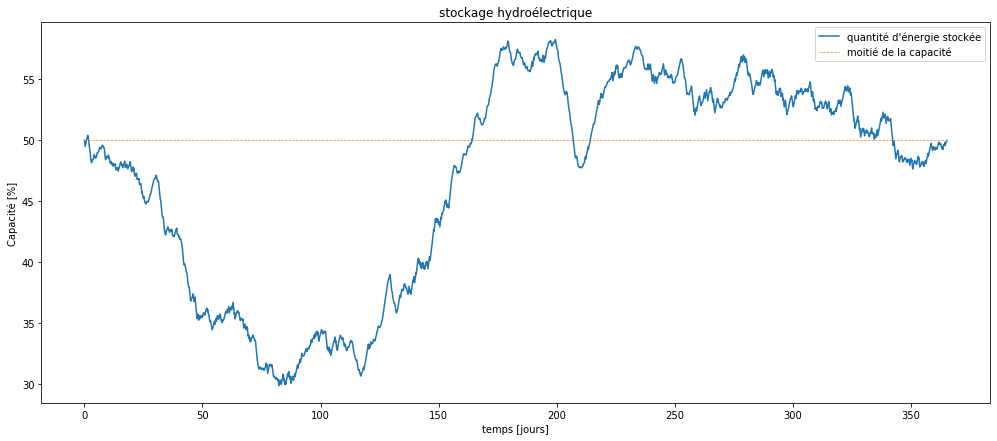

In [9]:
# Plot stockage hydroélectrique

X = np.arange(T, N+T, T)
Xb = np.arange(T, N+2*T, T)

plt.figure(figsize=(17,7))
plt.plot(Xb/24, solB/M*100)
plt.plot(Xb/24, [50]*len(solB), '--', linewidth=0.7)
plt.title('stockage hydroélectrique')
plt.legend(['quantité d\'énergie stockée', 'moitié de la capacité'])
plt.xlabel('temps [jours]')
plt.ylabel('Capacité [%]')
plt.show()

On peut voir que jusqu'aux 100 premiers jours la quantité d'énergie stockée ne fait que descendre car cela correspond à une période où la consommation est élevée tandis que des jours 120 à 170 la quantité d'énergie stockée remonte très fort car la consommation en électricité baisse.

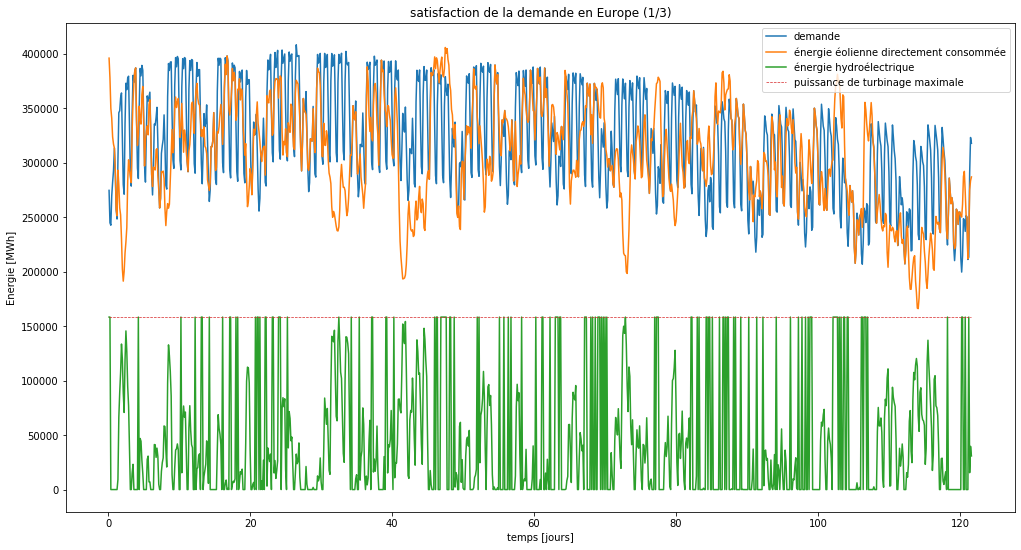

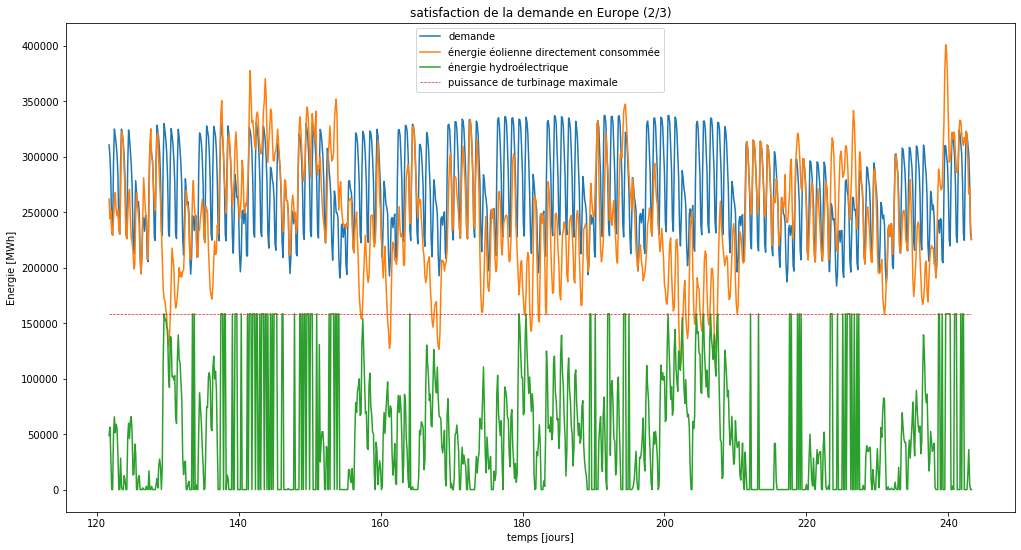

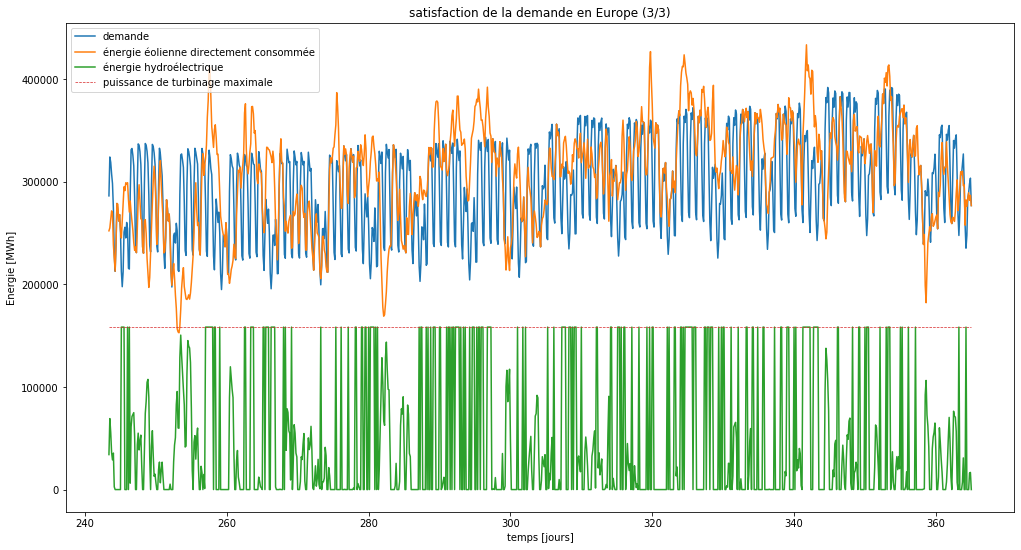

In [10]:
# Plot satisfaction de la demande

borne1 = N//T//3
borne2 = N//T//3*2

# satisfaction de la demande 1/3

plt.figure(figsize=(17,9))
plt.plot(X[:borne1]/24, D[:borne1]/T)
plt.plot(X[:borne1]/24, solE[:borne1]/T)
plt.plot(X[:borne1]/24, solHd[:borne1]/T)
plt.plot(X[:borne1]/24, [p_turbinage.sum()] * len(X[:borne1]), '--', linewidth=0.7)
plt.title('satisfaction de la demande en Europe (1/3)')
plt.legend(['demande', 'énergie éolienne directement consommée', 'énergie hydroélectrique', 'puissance de turbinage maximale'])
plt.xlabel('temps [jours]')
plt.ylabel('Energie [MWh]')
plt.show()

# satisfaction de la demande 2/3

plt.figure(figsize=(17,9))
plt.plot(X[borne1:borne2]/24, D[borne1:borne2]/T)
plt.plot(X[borne1:borne2]/24, solE[borne1:borne2]/T)
plt.plot(X[borne1:borne2]/24, solHd[borne1:borne2]/T)
plt.plot(X[borne1:borne2]/24, [p_turbinage.sum()] * len(X[borne1:borne2]), '--', linewidth=0.7)
plt.title('satisfaction de la demande en Europe (2/3)')
plt.legend(['demande', 'énergie éolienne directement consommée', 'énergie hydroélectrique', 'puissance de turbinage maximale'])
plt.xlabel('temps [jours]')
plt.ylabel('Energie [MWh]')
plt.show()

# satisfaction de la demande 3/3

plt.figure(figsize=(17,9))
plt.plot(X[borne2:]/24, D[borne2:]/T)
plt.plot(X[borne2:]/24, solE[borne2:]/T)
plt.plot(X[borne2:]/24, solHd[borne2:]/T)
plt.plot(X[borne2:]/24, [p_turbinage.sum()] * len(X[borne2:]), '--', linewidth=0.7)
plt.title('satisfaction de la demande en Europe (3/3)')
plt.legend(['demande', 'énergie éolienne directement consommée', 'énergie hydroélectrique', 'puissance de turbinage maximale'])
plt.xlabel('temps [jours]')
plt.ylabel('Energie [MWh]')
plt.show()

## Analyse post-optimale

Etant donné que beaucoup de nos contraintes sont en réalité considérées comme des simples bornes sur nos variables, nous avons mis un paramètre à la fonction qui nous permet de résoudre le problème lorsque nous avons besoin des variables duales c'est à dire lorsque les bornes doivent être considérées par le solveur comme des contraintes.
(Pour éviter d'avoir un modèle plus lent lorsque ce n'est pas nécessaire.)
Regardons maintenant combien rapporterait l'installation d'un MWh supplémentaire de stockage.
Pour cela nous allons regarder les variables du problème dual associées aux contraintes du problème primal qui sont impactées par un changement de la capacité de stockage hydroéléctriques. Il y a trois contraintes du problème primal qui varie lorsque la capacité de sotckage augmente. Ce sont les contraintes 'capa_stockage_hydro' , 'capa_init_hydro' , 'capa_final_hydro'. On peut voir que les variables duales associées à la contrainte 0 <= B <= M sont toujours nulle , ce qui se comprend assez aisément en observant le graphe. En effet on peut voir que pour notre solution optimale, la capacité hydroéléctrique maximale n'est jamais atteinte. Dès lors une augmentation de stockage ne modifie pas la valeur optimale. Les deux variables duales associées aux deux autres contraintes ont toujours des valeurs opposées. Ceci nous permet de voir que l'augmentation de la capacité de stockage n'aurait pas d'utilité car par la dualité forte nous avons que la valeur de la fonction objectif du dual est égale à la valeur de la fonction objectif du primal. Comme toutes les variables duales associées aux contraintes qui nous intéressent sont nulles ou s'annulent il n'y a pas de changement de la valeur de la fonction objectif du dual et donc pas de changement pour le primal non plus. (Le changement de la valeur objectif du dual est donnée par $\sum_{i=1}\Delta b*y_i$ où $\Delta b$ est la variation de la contrainte et $y_i$ est la valeur de la variable duale associée à la contrainte qui varie).  

In [11]:
s = resolution_prob1(8760,3,analyse_post_op = True)[0]

résolution: optimal


In [12]:
var_duale_hydro = s.dualConstraintSolution['capa_stockage_hydro']
var_duale_init  = s.dualConstraintSolution['capa_init_hydro']
var_duale_final = s.dualConstraintSolution['capa_final_hydro']

print(var_duale_init)
print(var_duale_final)
print(var_duale_hydro.sum())

[0.]
[0.]
0.0


Regardons maintenant ce qu'il en est si l'on augmente de un MW la puissance de pompage. Pour cela regardons les variables duales associées à la contrainte appelée "ajout énergie hydro". C'est en effet la seule contrainte impactée lors d'une modification de la puissance de pompage. Nous nous rendons bien compte qu'augmenter la puissance de pompage ne peut augmenter le prix optimal étant donné que le modèle est juste moins contraint. On en conclut, malgré que les variables duales soient positives , qu'une petite augmentation de la capacité de pompage ne change pas la solution optimale.

In [13]:
var_duale_ajout_energie_hydro = s.dualConstraintSolution['ajout_énergie_hydro']
print(sum(var_duale_ajout_energie_hydro))

527920.2623865787


Regardons l'effet de l'installation d'un MW suppléméntaire de turbinage. Nous allons donc regarder les variables duales associées à la contrainte appelée "hydro_vers_conso".On peut voir que cette installation engendrerait une diminution du cout optimal donné par l'opposée de var_duale_turbi.sum() 

In [13]:
var_duale_turbi = s.dualConstraintSolution['hydro_vers_conso']
print(var_duale_turbi.sum())

-527920.2623865787


On remarque que ces deux valeurs sont égales en valeurs absolues mais de signes opposés. Cela veut dire que si l'on augmentait la puissance trubinage/pompage cela aurait comme effet sur le prix totale une augmentation de la somme de ces deux valeurs, qui vaut 0 puisque $var\_duale\_pompage = -var\_duale\_turbinage$. Donc il n'y aurait pas de différences sur le prix total.

## Situation II.2

Pour cette deuxième partie, le solveur a dû choisir pour chaque site entre installer 100%, 50% ou 0% de la capacité maximale. Une manière d'implementer ce modèle est d'utiliser des variables entières. Nous allons imposer ici que les variables $x_i$ valent soit 0,1 ou 2. La contrainte est donc 0 <= x <=2 avec les composantes du vecteur x qui sont des valeurs entières. Nous allons aussi transformer le vecteur capacité (qui contient les capacités maximales installables des différents sites) en le divisant par deux et en mettant les composantes de ce nouveau vecteur dans la diagonale d'une matrice appelée matrix_capa (Les autres éléments de cette matrice sont nuls). De cette manière si on multiplie cette matrice avec le vecteur x on obtient un vecteur (matrix_capa * x) qui contient les puissances installées sur les différents sites.
Les autres contraintes et variables restent les mêmes.

In [6]:
def resolution_prob2(N, T):
    
    
    apports = apports_entire[:,:N] # shape: (15, N)
    consommations = consommations_entire[:,:N] # shape: (15, N)
    rend_off = rend_off_entire[:,:N] # shpae: (642, N)
    rend_on = rend_on_entire[:,:N] # shape: (642, N)
    M = stockage_hydro.sum() # scalar 
    P_p = p_pompage.sum() # scalar
    P_t = p_turbinage.sum() # scalar

    rend = matrix_rendement(rend_off, rend_on, sites) # shape: (642, N)
    I = np.matrix(np.eye(nb_site)) # shape: (642, 642)
    A = CyLPArray(matrix_sum_periods(N, T)@sum_by_col(apports,N))[0] # shape: (N/T,)
    D = CyLPArray(matrix_sum_periods(N, T)@sum_by_col(consommations, N))[0] # shape: (N/T,)
    R = np.matrix(matrix_sum_periods(N,T)@rend.T) # shape: (N/T, 642)
    
    half_capacites = capacites / 2
    matrix_capa = vector_to_matrix(half_capacites,nb_site)
    
    
    # Variables
    model = CyLPModel()
    X   = model.addVariable('X', nb_site)
    B   = model.addVariable('B', N//T + 1)
    H_m = model.addVariable('H_m', N//T)
    H_d = model.addVariable('H_d', N//T)
    E   = model.addVariable('E', N//T)


    # Contraintes
    model.addConstraint(E + H_d >= D)
    model.addConstraint(var_matrix(N//T)*B - H_m + np.matrix(np.eye(N//T)/eta_turbinage)*H_d == A)
    model.addConstraint((R@matrix_capa)*X - E - H_m == 0)

    model.addConstraint(0 <= B <= M)
    model.addConstraint(0 <= H_m <= T*P_p)
    model.addConstraint(0 <= H_d <= T*P_t)
    model.addConstraint(0 <= X <= 2)
    
    model.addConstraint(B[0] == M/2)
    model.addConstraint(B[-1] == M/2)
    
    
    # Objectif
    C = vecteur_OffouOn(sites, nb_site, N)
    O = C @ matrix_capa
    model.objective = O*X
    
    
    
    s = CyClpSimplex(model)
    s.setInteger(X)
    cbcModel = s.getCbcModel()
    
    
    start = time.time()
    cbcModel.solve()                  #branchAndBound()
    end = time.time()
    

    
    return cbcModel, (end-start), D

In [7]:
N = 7*24
T = 3

print("N = {}\nT = {}\nNombre de site = {}\n".format(N, T,nb_site))

s2 , time_taken , D2  = resolution_prob2(N,T)
solHd2 = s2.primalVariableSolution['H_d']
solE2  = s2.primalVariableSolution['E']
solB2  = s2.primalVariableSolution['B']
solX2  = s2.primalVariableSolution['X']
solHm2 = s2.primalVariableSolution['H_m']

print("prix total de la production de l'énergie éléctrique : {:.2f} milliards d\'€".format(s2.objectiveValue/1e9))
print("pourcentage de la consommation d'énergie satisfaite par l'hydroéléctrique : {:.2f} %".format(solHd2.sum() *100 /D2.sum()))
print("pourcentage de la consommation d'énergie satisfaite par l'éolien: {:.2f} %".format(solE2.sum()*100 /D2.sum()))
print("pourcentage de l'énergie produite qui est consommée: {:.2f} %".format(100*D2.sum()/(solE2.sum()+solHd2.sum())))
print("prix moyen d'éléctricité consommée : {:.2f} €/MWh".format(s2.objectiveValue/(D2.sum())))
print("Temps de résolution: {:.0f} min {:.3f} sec".format(time_taken//60, time_taken % 60))

N = 168
T = 3
Nombre de site = 642

prix total de la production de l'énergie éléctrique : 2.28 milliards d'€
pourcentage de la consommation d'énergie satisfaite par l'hydroéléctrique : 9.85 %
pourcentage de la consommation d'énergie satisfaite par l'éolien: 91.94 %
pourcentage de l'énergie produite qui est consommée: 98.24 %
prix moyen d'éléctricité consommée : 41.63 €/MWh
Temps de résolution: 0 min 1.391 sec


Nous obtenons sans surprise une valeur optimale plus grande que celle obtenue au point 1. Ceci s'explique simplement par le fait que le poblème 2 est le même que le problème 1 auquel on a rajouté une contrainte supplémentaire. Il ne peut donc avoir une valeur optimale que plus grande ou égale à celle obtenue lors de la résolution du problème 1 (le cas avec un coût égal est très improbable). Nous pouvons aussi observer une grande augmentation du temps d'exécution entre le problème 1 et le problème 2. Cette augmentation est représentée sur le graphe ci-dessous.

## Graphe du temps d'éxecution en fonction du nombre d'heures considérées

In [16]:
N = 1600

temps_exec_prob1 = []
temps_exec_prob2 = []
N_vector = np.array([(i+1)*N//7 for i in range(7)])    

for N_ in N_vector:    
    temps_exec_prob1.append(resolution_prob1(N_, T,verbose=False)[1])

for N_ in N_vector[:4]:    
    temps_exec_prob2.append(resolution_prob2(N_, T)[1])

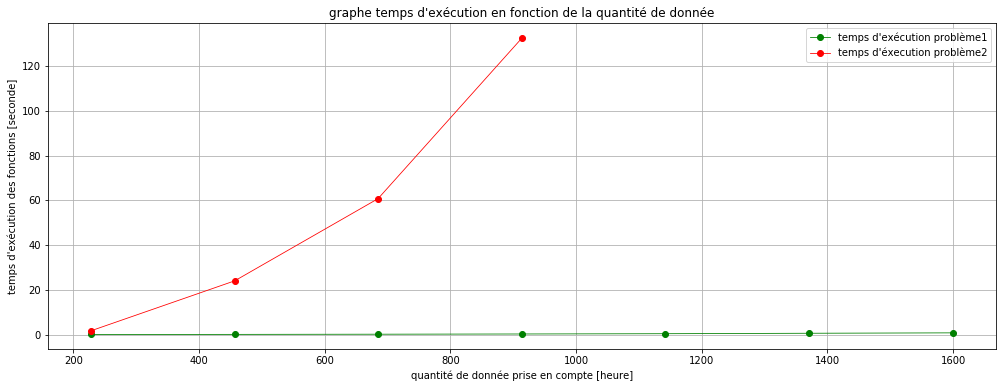

In [17]:
plt.figure(figsize=(17,6))
plt.plot(N_vector, temps_exec_prob1, '-og', linewidth=0.8)
plt.plot(N_vector[:4], temps_exec_prob2, '-or', linewidth=0.8)
plt.xlabel('quantité de donnée prise en compte [heure]')
plt.ylabel('temps d\'exécution des fonctions [seconde]')
plt.title('graphe temps d\'exécution en fonction de la quantité de donnée')
plt.grid()
plt.legend(['temps d\'exécution problème1', 'temps d\'éxecution problème2'])
plt.show()

Nous pouvons observer que le problème 1 est très rapide même pour un nombre d'heures considéré assez grand, cela s'explique par le fait que beaucoup de nos contraintes sont en réalité des simples bornes sur nos variables et sont donc traitées par le solveur directement au niveau de l'algoritme simplexe. Le temps d'éxécution du problème 2 est quant à lui assez raisonnable pour un petit nombre d'heures considérées mais grandit de manière exponentielle lorsque le nombre d'heures augmente. Ceci s'explique par le fait que le nombres de noeuds potentiels à explorer par l'algorithme augmente de manière exponentielle. En pratique, il existe plusieurs solutions pour contrer ce problème. La première consiste simplement à donner une marge d'erreur acceptable de sorte que l'algorithme s'arrète dès que l'écart entre la plus grande borne inférieure et la plus petit borne supérieure (calculée par l'algorithme) est plus petit que cette marge d'erreur. Une deuxième consisterait à donner une petit marge d'erreur sur les variables qui doivent être entières de telle manière à ce que l'algorithme s'arrète si la solution est optimale et que les variables sont proche d'un nombre entier. Le solveur Cbc possède toutes ces fonctionnalités.

## Situation II.3

Nous allons maintenant regarder ce que donne le modèle de la situation 1 si nous l'appliquons à chaque pays de manière individuelle.

In [18]:
def resolution_prob3(N, T, pays, verbose=True):
    
    i = liste_pays.index(pays)
    
    apports = apports_entire[:,:N] # shape: (15, N)
    consommations = consommations_entire[:,:N] # shape: (15, N)
    rend_off = rend_off_entire[:,:N] # shpae: (642, N)
    rend_on = rend_on_entire[:,:N] # shape: (642, N)
    rend = matrix_rendement(rend_off, rend_on, sites) # shape: (642, N)
    
    sites_pays = sites[sites['pays'] == pays]
    apports_pays = apports[i]
    consommations_pays = consommations[i]
    nb_sites_pays = len(sites_pays)
    capacites_pays = sites[sites['pays']==pays]['capacites']
    
    rend_pays = np.matrix(np.empty((nb_sites_pays, N))) # shape: (nb_sites_pays, N)
    for idx, j in enumerate(np.array(sites_pays['index site'])):
        rend_pays[idx] = np.array(rend)[j]
    
    M = stockage_hydro[i]
    P_p = p_pompage[i]
    P_t = p_turbinage[i]
    
    I = np.matrix(np.eye(nb_sites_pays))
    A = CyLPArray(matrix_sum_periods(N, T)@apports_pays)[0]
    D = CyLPArray(matrix_sum_periods(N, T)@consommations_pays)[0]
    R = np.matrix(matrix_sum_periods(N,T)@rend_pays.T)
    
    model = CyLPModel()
    X   = model.addVariable('X', nb_sites_pays)
    B   = model.addVariable('B', N//T +1 )
    H_m = model.addVariable('H_m', N//T )
    H_d = model.addVariable('H_d', N//T)
    E   = model.addVariable('E', N//T )


    # Contraintes
    model.addConstraint(E + H_d >= D)
    if R.shape[1] == 1:
        model.addConstraint(X*R - E - H_m == 0)
    else:
        model.addConstraint(R*X - E - H_m == 0)
    model.addConstraint(var_matrix(N//T)*B - H_m + np.matrix(np.eye(N//T)/eta_turbinage)*H_d == A)

    model.addConstraint(0 <= X <= capacites_pays, 'capacitee')
    model.addConstraint(0 <= B <= M)
    model.addConstraint(0 <= H_m <= T*P_p)
    model.addConstraint(0 <= H_d <= T*P_t)

    model.addConstraint(B[0] == M/2)
    model.addConstraint(B[-1] == M/2)


    # Objectif
    C = vecteur_OffouOn(sites_pays, nb_sites_pays, N)
    model.objective =  C * X


    s = CyClpSimplex(model)
    
    start = time.time()
    result = s.dual()
    end = time.time()
    
    if verbose:
        print('{}: {}'.format(pays, result))
    
    return result, s, (end-start), np.array(D), np.array(A), np.array(R)

In [19]:
# Paramètres
N = 8760
T = 3

for pays in liste_pays:
    res = resolution_prob3(N, T, pays)
    
    if res[0] == 'optimal':
        print('    Prix: {:.2f} euros/MWh'.format(res[1].objectiveValue/res[3].sum()))
        energieProduite = (res[5]@res[1].primalVariableSolution['X']).sum()
        energieConsommee = res[3].sum()
        print('    Energie consommée / énergie éolienne produite: {:.2f}%'.format(energieConsommee/energieProduite*100))

Allemagne: primal infeasible
Autriche: primal infeasible
Belgique: primal infeasible
Danemark: primal infeasible
Espagne: optimal
    Prix: 68.00 euros/MWh
    Energie consommée / énergie éolienne produite: 77.92%
France: primal infeasible
Irlande: primal infeasible
Italie: primal infeasible
Luxembourg: primal infeasible
Norvège: optimal
    Prix: 7.06 euros/MWh
    Energie consommée / énergie éolienne produite: 603.88%
Pays-Bas: primal infeasible
Portugal: primal infeasible
Royaume-Uni: primal infeasible
Suède: optimal
    Prix: 46.58 euros/MWh
    Energie consommée / énergie éolienne produite: 120.47%
Suisse: optimal
    Prix: 37.08 euros/MWh
    Energie consommée / énergie éolienne produite: 214.67%


On voit dans les résultats que la Norvège obtient un prix incroyable de 7 euros/MWh d'électricité consommée, cela peut s'expliquer par la rapport énergie consommée / énergie éolienne produite valant plus 6 ce qui veut dire qu'une grande partie de sa consommation d'électricité vient en fait des apports naturels en eau dans les reserves hydroélectriques qui ne lui coûte absolument rien. Il en est de même pour la Suisse et la Suède.

Touts les autres pays, hormis l'Espagne, ne disposent pas d'assez de puissance pompage-turbinage pour satisfaire leur consommation lors des périodes avec moins de vent, ce qui explique pourquoi le solveur ne trouve pas de solution possible au problème.

### Exemple 1: l'Allemagne, pas de solution possible

Allemagne: primal infeasible


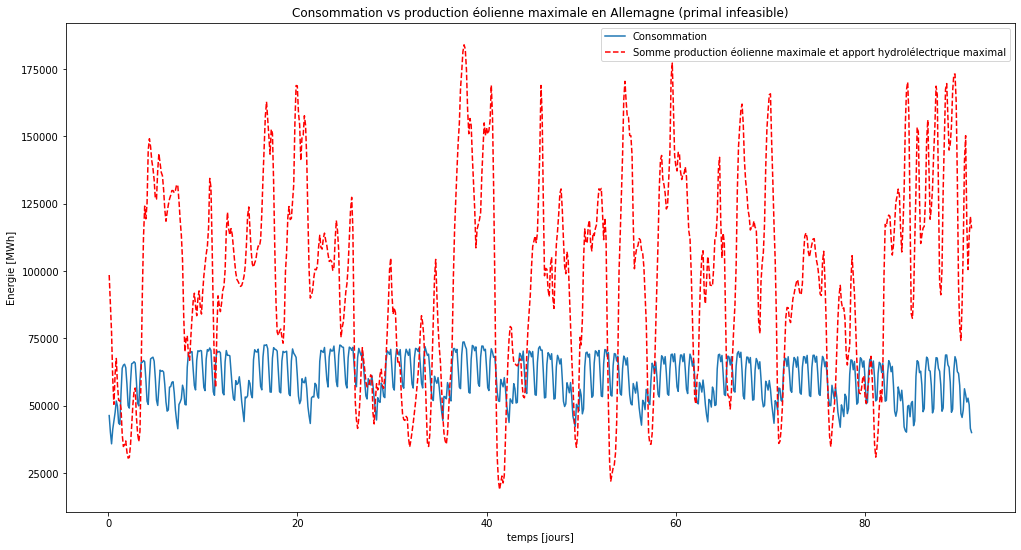

In [20]:
pays = 'Allemagne'
N = 8760//4
T = 3

result, s, t, D, A, R = resolution_prob3(N, T, pays)
capacites_pays = np.array(sites[sites['pays'] == pays]['capacites'])

X = np.arange(T, N+T, T)

plt.figure(figsize=(17,9))
plt.plot(X/24, D/T) # Consommation
plt.plot(X/24, R@capacites_pays/T + p_turbinage[liste_pays.index(pays)], '--r') # Production éolienne maximale + apport hydrolélectrique
plt.title('Consommation vs production éolienne maximale en {} ({})'.format(pays, result))
plt.legend(['Consommation', 'Somme production éolienne maximale et apport hydrolélectrique maximal'])
plt.xlabel('temps [jours]')
plt.ylabel('Energie [MWh]')
plt.show()

L'Allemagne, comme beaucoup d'autres pays, ne peux pas satisfaire entièremment sa consommation électrique uniquement par l'éolien et l'hydrolélectrique. Sur le graphe ci-dessus, la courbe en rouge pointillé représente l'énergie maximale que l'Allemagne pourrait produire à chaque période de temps, c'est-à-dire si les turbines hydroélectriques fonctionnaient 24h/24 et si toutes la puissance éolienne possible étaient installée (situation évidemment impossible). On remarque que cette courbe de production maximale passe souvent en dessous de celle de la consommation électrique, ce qui veut dire que assez régulièremment la population Allemande subira des épisodes de pénuries d'électricité même si en moyenne elle produit plus d'électricité qu'elle en consomme.

### Exemple 2: la Norvège, production basée sur l'hydroélectrique

Norvège: optimal


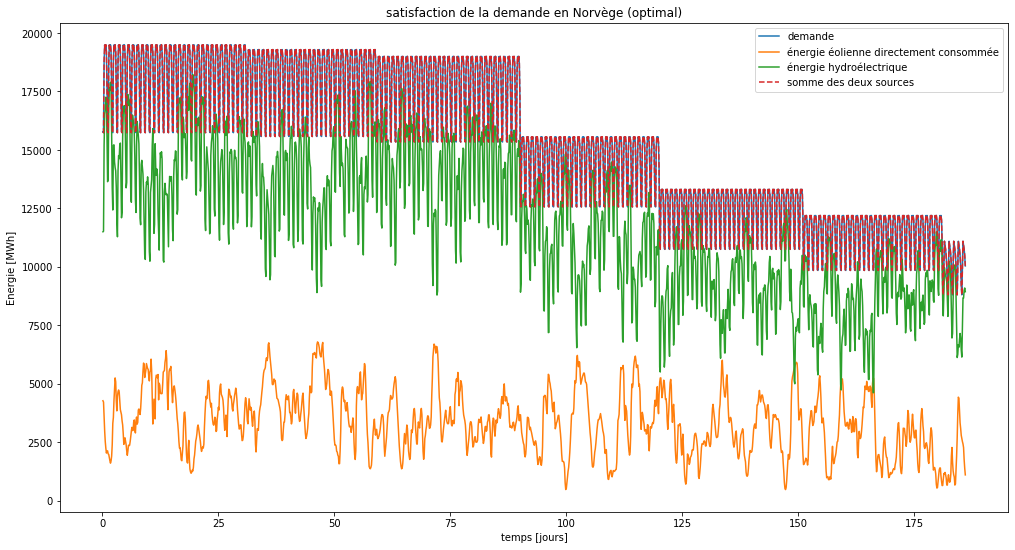

    Test de validation des contraintes pour Norvège
test capacites: OK
test différence barrage: OK
test demande: OK
test production: OK
test stockage : OK
test pompage: OK
test turbinage: OK


In [30]:
pays = 'Norvège'
N = 31*6*24
T = 3

result, s, t, D, A, R = resolution_prob3(N, T, pays)

X = np.arange(T, N+T, T)

plt.figure(figsize=(17,9))
plt.plot(X/24, D/T) # Consommations
plt.plot(X/24, s.primalVariableSolution['E']/T)
plt.plot(X/24, s.primalVariableSolution['H_d']/T)
plt.plot(X/24, s.primalVariableSolution['E']/T + s.primalVariableSolution['H_d']/T, '--')
plt.title('satisfaction de la demande en {} ({})'.format(pays, result))
plt.legend(['demande', 'énergie éolienne directement consommée', 'énergie hydroélectrique', 'somme des deux sources'])
plt.xlabel('temps [jours]')
plt.ylabel('Energie [MWh]')
plt.show()

test_resultat(pays, s.primalVariableSolution['X'], s.primalVariableSolution['B'], s.primalVariableSolution['H_m'], s.primalVariableSolution['H_d'], s.primalVariableSolution['E'], A, D, R)

total des apports naturels: 136366154.7 MWh
total de la consomaation  : 122572078.7 MWh
perte d'énergie           : 0.00000 MWh


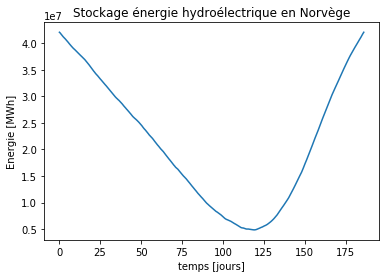

In [31]:
i = liste_pays.index(pays)
print('total des apports naturels: {} MWh'.format(apports_entire[i].sum()))
print('total de la consomaation  : {} MWh'.format(consommations_entire[i].sum(), 'MWh'))
print('perte d\'énergie           : {:.5f} MWh'.format((s.primalVariableSolution['E'] + s.primalVariableSolution['H_d'] - D).sum()))

plt.plot(np.arange(T, N+2*T, T)/24, s.primalVariableSolution['B'])
plt.xlabel('temps [jours]')
plt.ylabel('Energie [MWh]')
plt.title('Stockage énergie hydroélectrique en {}'.format(pays))
plt.show()

Dans le cas de la Norvège on remarque que la majorité de la production d'électricité vient de l'hydroélectrique. En fait, si on compare le total des apports naturels hydroélectrique au total de la consommation, on voit que les apports naturels surpassent légèremment la consommation donc, en théorie, la Norvège pourrait totalement se passer de l'éolien pour satisfaire sa consommation nationale mais elle en a quand même besoin pour reremplir ses stocks hydroélectrique lorsque les périodes de grande consommation sont trop longue (l'hiver, jour 0 - 120) et que les stocks descendent trop bas.

De plus la Norvège possède la plus grande puissance de turbinage d'Europe ce qui lui permet d'être indépendante de la variabilité du vent. Lorsqu'il y a beaucoup de vent, les turbines tournent moins et les barrages se chargent tandis que quand il n'y a pas de vent, les turbines peuvent produire beaucoup plus et toujours satisfaire la consommation. Cette flexibilitée lui permet aussi de ne jamais gaspiller d'énergie, on peut le voir sur le graphe grâce au fait que la somme des deux sources d'électricité est toujours égale à la consommation.

### Exemple 3: l'Espagne

Espagne: optimal


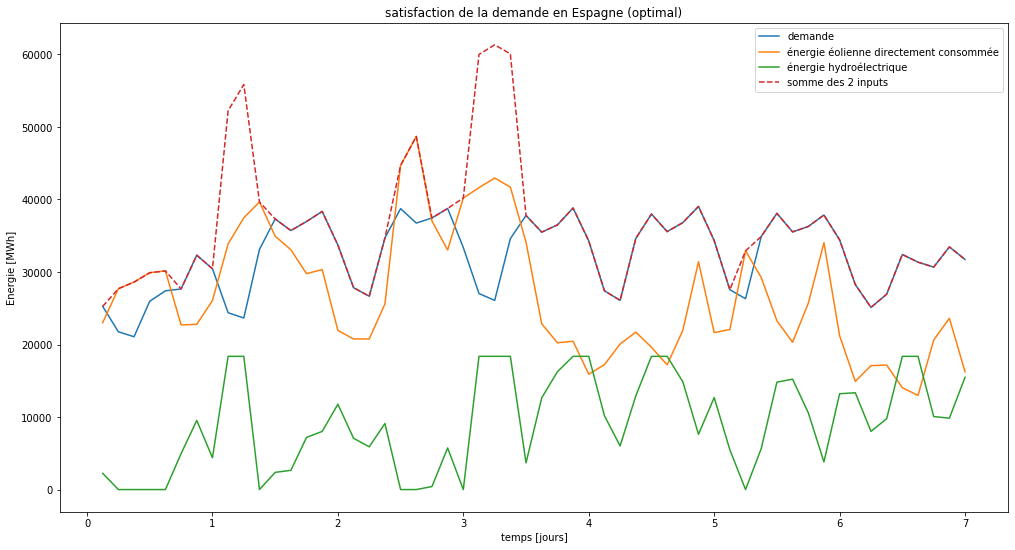

    Test de validation des contraintes pour Espagne
test capacites: OK
test différence barrage: OK
test demande: OK
test production: OK
test stockage : OK
test pompage: OK
test turbinage: OK


In [23]:
pays = 'Espagne'
N = 8760
T = 3

result, s, t, D, A, R = resolution_prob3(N, T, pays)

a = int(7*24//3)                 #on regarde la s2 pour bien voire la diff avec le point 4.
X = np.arange(T, 7*24+T, T)

plt.figure(figsize=(17,9))
plt.plot(X/24, D[a:2*a]/T) # Consommations
plt.plot(X/24, s.primalVariableSolution['E'][a:2*a]/T)
plt.plot(X/24, s.primalVariableSolution['H_d'][a:2*a]/T)
plt.plot(X/24, s.primalVariableSolution['E'][a:2*a]/T + s.primalVariableSolution['H_d'][a:2*a]/T, '--')
plt.title('satisfaction de la demande en {} ({})'.format(pays, result))
plt.legend(['demande', 'énergie éolienne directement consommée', 'énergie hydroélectrique', 'somme des 2 inputs'])
plt.xlabel('temps [jours]')
plt.ylabel('Energie [MWh]')
plt.show()

test_resultat(pays, s.primalVariableSolution['X'], s.primalVariableSolution['B'], s.primalVariableSolution['H_m'], s.primalVariableSolution['H_d'], s.primalVariableSolution['E'], A, D, R)

In [24]:
print('puissance de turbinage / consommation moyenne : {:.2f} %'.format(p_turbinage[liste_pays.index('Espagne')]/consommations_entire[liste_pays.index('Espagne')].sum()*8760*100))
print('perte d\'énergie                               : {:.2f} MWh ({:.2f} % de la consommation totale)'.format((s.primalVariableSolution['E'] + s.primalVariableSolution['H_d'] - D).sum(), (s.primalVariableSolution['E'] + s.primalVariableSolution['H_d'] - D).sum() / D.sum() *100))

puissance de turbinage / consommation moyenne : 63.52 %
perte d'énergie                               : 91243391.64 MWh (36.01 % de la consommation totale)


l'Espagne a réussi à avoir une solution au problème grâce à sa relativement grande puissance de turbinage par rapport à sa consommation et au fait qu'il n'y ai pas eu de période avec trop peu de production d'énergie éolienne. Par contre il y a eu énormément de gaspillage d'énergie (environ 36% de la consommation totale). C'est dû au fait que l'Espagne a dû installer une grande puissance éolienne pour les périodes avec peu de vent mais en contrepartie il y a du surplus lorsqu'il y a beaucoup de vent. Cela explique le fait que le prix moyen en Espagne soit de 68 euros/MWh.

### Situation II.4

Dans cette dernière situation, les pays ont maintenant la possibilité d'installer des centrales au gaz. Cette possibilité d'installation change légèrement le problème linéaire du premier point.


On ajoute les variables $G_i$ qui représente la quantité d'énergie produite par la centrale de gaz (en MWh) durant la période $i$ (elles sont donc au nombre de $N/T$).
On ajoute aussi une variable $G_{inst}$ qui a pour objectif de déterminer la puissance des centrales au gaz minimale nécessaire à satisfaire la demande d'énergie à chaque période.

La contrainte  $E_i + H_{d,i} \ge D_i$ est remplacée par la contrainte  $E_i + H_{d,i} + G_i\ge D_i$ qui tient compte de l'énergie apportée par les centrales au gaz pour satisfaire la demande à chaque période.
Nous devons aussi ajouter la contrainte $G_i \ge 0$ qui impose que les quantités d'énergie produitent par les centrales au gaz ne peuvent pas être négative.
Pour déterminer la puissance des centrales au gaz à installer nous avons imposé que la variable $G_{inst}$ soit plus grande ou égale à toute les variables $G_i$. De telle manière $G_{inst}$ vaut la quantité d'énergie maximale à apporter par les centrales au gaz lors de la période la plus critique (celle ou l'écart entre la demande et l'apport d'énergie par les éoliennes et le turbinage est le plus grand). En divisant $G_{inst}$ par la période T , on trouve la puissance maximale qu'il faut installer pour les centrales au gaz.

Nous avons aussi une nouvelle fonction objectif donnée par :$$\min c_{onshore} \sum_{i \in O} x_i + c_{offshore} \sum_{i \in F} x_i + g \cdot G + b G_{inst} $$ 

où $g$ est un vecteur de taille N/T dont chaque composante vaut $g_i = cout\_utilisation\_gaz$. De telle manière, le produit scalaire entre $g$ et $G$ représente le coût de fonctionnement des centrales au gaz sur toute l'année.
Le scalaire $b$ représente le coût total amorti de l'installation des centrales au gaz, multiplié par le facteur $N/(8760T)$ (pour tenir compte de la période d'utilisation).

Les autres contraintes et variables sont les mêmes que celle décrite au point 1.
Dans ce modèle on s'attend clairement à ce que chaque pays puisse satisfaire sa demande étant donné qu'il n'y a aucune limitation sur la puissance des centrales au gaz que l'on peut installer. Chaque pays devrait donc avoir une solution omptimale.



In [25]:
# Paramètres
N = 8760
T = 3

# Constantes
apports = apports_entire[:,:N] # shape: (15, N)
consommations = consommations_entire[:,:N] # shape: (15, N)
rend_off = rend_off_entire[:,:N] # shape: (642, N)
rend_on = rend_on_entire[:,:N] # shape: (642, N)
rend = matrix_rendement(rend_off, rend_on, sites) # shape: (642, N)

solB_pays = []
solX_pays = []
solHm_pays = []
solHd_pays = []
solE_pays = []
solG_pays = []
D_pays = []
R_pays = []
A_pays = []
capa_pays = []
result_pays = []
objectif_pays = []
for i, pays in enumerate(liste_pays):
    sites_pays = sites[sites['pays'] == pays]
    apports_pays = apports[i]
    consommations_pays = consommations[i]
    nb_sites_pays = len(sites_pays)
    capacites_pays = sites[sites['pays']==pays]['capacites']
    
    rend_pays = np.matrix(np.empty((nb_sites_pays, N))) # shape: (nb_sites_pays, N)
    for idx, j in enumerate(np.array(sites_pays['index site'])):
        rend_pays[idx] = np.array(rend)[j]
    
    M = stockage_hydro[i]
    P_p = p_pompage[i]
    P_t = p_turbinage[i]
    
    I = np.matrix(np.eye(nb_sites_pays))
    I1 = np.matrix(np.eye(N//T))
    A = CyLPArray(matrix_sum_periods(N, T)@apports_pays)[0]
    D = CyLPArray(matrix_sum_periods(N, T)@consommations_pays)[0]
    R = np.matrix(matrix_sum_periods(N,T)@rend_pays.T)
    
    model = CyLPModel()
    X   = model.addVariable('X', nb_sites_pays)
    B   = model.addVariable('B', N//T + 1)
    H_m = model.addVariable('H_m', N//T)
    H_d = model.addVariable('H_d', N//T)
    E   = model.addVariable('E', N//T)
    G   = model.addVariable('G', N//T)               #puissance utilisée à chaque période
    G_inst = model.addVariable('G_inst',1)
    


    # Contraintes
    model.addConstraint(E + H_d + G >= D)
    if R.shape[1] == 1:
        model.addConstraint(X*R - E - H_m == 0)
    else:
        model.addConstraint(R*X - E - H_m == 0)
    model.addConstraint(var_matrix(N//T)*B - H_m + np.matrix(np.eye(N//T)/eta_turbinage)*H_d == A)

    model.addConstraint(0 <= X <= capacites_pays, 'capacitee')
    model.addConstraint(0 <= B <= M)
    model.addConstraint(0 <= H_m <= T*P_p)
    model.addConstraint(0 <= H_d <= T*P_t)
    model.addConstraint(0 <= G)
    for i in range(N//T):
        model.addConstraint(G[i] - G_inst <= 0)
 
    

    model.addConstraint(B[0] == M/2)
    model.addConstraint(B[-1] == M/2)


    # Objectif
    C = vecteur_OffouOn(sites_pays, nb_sites_pays, N)
    g_fonct = CyLPArray(cout_fonct_gaz*np.ones(N//T))
    
    
    model.objective =  C * X +  g_fonct*G  + (cout_amorti_gaz * N/(8760*T))*G_inst 


    s = CyClpSimplex(model)

    result = s.dual()
    print('    ', pays, ':')
    print(result)
    if result == 'optimal':
        print('solution    :', s.objectiveValue)
        #print('prod:', (R@s.primalVariableSolution['X']).sum())
        print('prix par MWh:', s.objectiveValue/D.sum())
    print()
 
    solB_pays.append(s.primalVariableSolution['B'])
    solX_pays.append(s.primalVariableSolution['X'])
    solHm_pays.append(s.primalVariableSolution['H_m'])
    solHd_pays.append(s.primalVariableSolution['H_d'])
    solE_pays.append(s.primalVariableSolution['E'])
    solG_pays.append(s.primalVariableSolution['G'])
    D_pays.append(D)
    R_pays.append(np.array(R))
    A_pays.append(A)
    capa_pays.append(np.array(capacites_pays))
    result_pays.append(result)
    objectif_pays.append(s.objectiveValue)

     Allemagne :
optimal
solution    : 30617827388.3337
prix par MWh: 62.60415480615161

     Autriche :
optimal
solution    : 2033951154.2122428
prix par MWh: 35.320836013423886

     Belgique :
optimal
solution    : 6151469289.134331
prix par MWh: 68.07514348289301

     Danemark :
optimal
solution    : 2167474088.384347
prix par MWh: 59.55909476722698

     Espagne :
optimal
solution    : 12466435525.321268
prix par MWh: 49.20488700942532

     France :
optimal
solution    : 25247696254.0008
prix par MWh: 52.96493159507867

     Irlande :
optimal
solution    : 1781875160.4761045
prix par MWh: 63.62808493035141

     Italie :
optimal
solution    : 18396433550.706753
prix par MWh: 55.03909763373944

     Luxembourg :
optimal
solution    : 509162467.2063599
prix par MWh: 76.54610125912885

     Norvège :
optimal
solution    : 865671763.4318691
prix par MWh: 7.062552684209876

     Pays-Bas :
optimal
solution    : 8155922765.7154
prix par MWh: 73.8794171753336

     Portugal :
optimal
s

Nous pouvons observer que tous les pays ont une solution optimale comme attendu. Nous pouvons aussi observer que toutes les solutions optimales sont plus faibles ou égale (égale uniquement dans le cas de la Norvège) que les solutions obtenues au point 3. Une solution optimale plus importante n'aurait pas de sens car le pays déciderait alors de ne pas installer de centrales au gaz, comme par exemple la Norvège, qui grace a son grand apport en énergie naturelle n'a pas besoin d'en installer.
Analysons les solutions optimales de certains pays sur un graphe. Prenons par exemple le cas de l'Allemagne et de l'Espagne. Nous avons vu à la situation 3 que l'Allemagne n'arrivait pas à satisfaire la demande en énergie lors de certaines périodes, ce qui rendait le problème impossible car certaines contraintes n'étaient pas vérifiées. Pour ce qui est de l'Espagne nous avions vu que l'énergie perdue était très importante, nous montrons plus bas l'utilité des centrales au gaz pour limiter ce gaspillage d'énergie. Pour plus de lisibilité, nous regardons uniquement les graphes sur des périodes de une semaine.

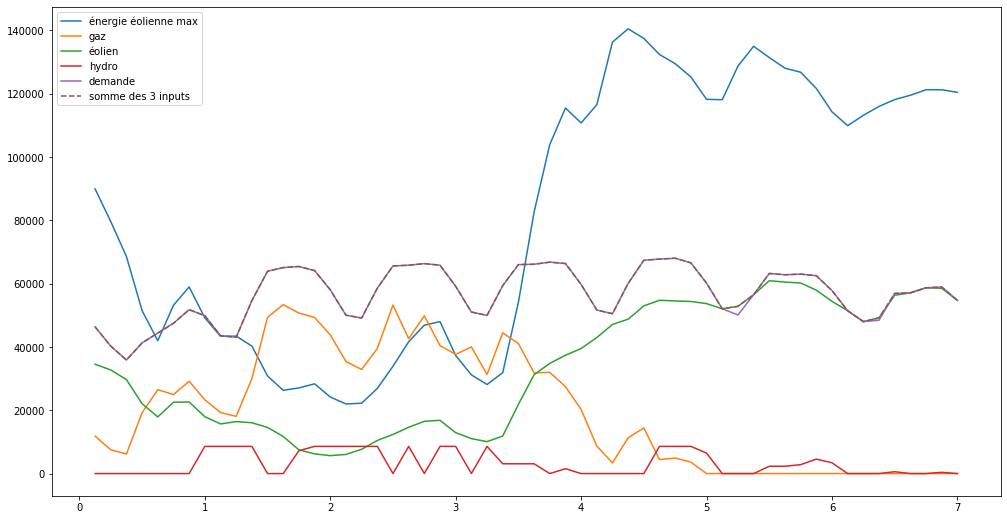

In [33]:
i = liste_pays.index('Allemagne')

plt.figure(figsize=(17,9))
X = np.arange(T,7*24+T,T)
a = int(7*24//3)

plt.plot(X/24,(R_pays[i]@capa_pays[i])[:a]/T)
plt.plot(X/24,solG_pays[i][:a]/T)
plt.plot(X/24,solE_pays[i][:a]/T)
plt.plot(X/24,solHd_pays[i][:a]/T)
plt.plot(X/24,D_pays[i][:a]/T)
plt.plot(X/24,solG_pays[i][:a]/T+solE_pays[i][:a]/T+solHd_pays[i][:a]/T, '--')
plt.legend(['énergie éolienne max','gaz', 'éolien', 'hydro', 'demande', 'somme des 3 inputs'])

On peut voir sur le graphe une augmentation de production d'énergie par les centrales au gaz lorsque l'énergie venant de l'éolien est plus faible et une chute de celle ci lorsque l'énergie provenant des éoliennes augmente à nouveau. Les centrales au gaz permettent de combler les manques d'énergie, avec l'avantage de ne pas dépendre de facteur aléatoire tel que le vent.  

perte d'énergie : 3852623.26 MWh (1.52 % de la consommation totale)


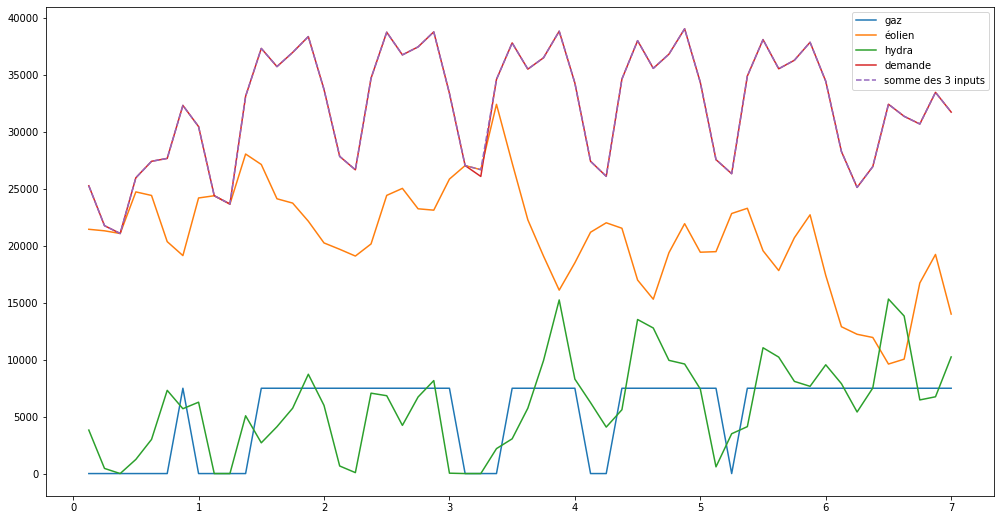

In [34]:
i = liste_pays.index('Espagne')
print('perte d\'énergie : {:.2f} MWh ({:.2f} % de la consommation totale)'.format((solE_pays[i] + solHd_pays[i] +solG_pays[i] - D_pays[i]).sum(), (solE_pays[i] + solHd_pays[i] +solG_pays[i] - D_pays[i]).sum() / D_pays[i].sum() *100))

plt.figure(figsize=(17,9))
X = np.arange(T,7*24+T,T)
a = int(7*24//3)

plt.plot(X/24,solG_pays[i][a:2*a]/T)
plt.plot(X/24,solE_pays[i][a:2*a]/T)
plt.plot(X/24,solHd_pays[i][a:2*a]/T)
plt.plot(X/24,D_pays[i][a:2*a]/T)
plt.plot(X/24,solG_pays[i][a:2*a]/T+solE_pays[i][a:2*a]/T+solHd_pays[i][a:2*a]/T, '--')
plt.legend(['gaz', 'éolien', 'hydra', 'demande', 'somme des 3 inputs'])

Nous pouvons voir que l'installation de centrale au gaz , permet un apport beaucoup plus controlé de l'énergie ce qui permet à l'Espagne de passer de 91 millions MWh à 3,8 millions MWh d'énergie gaspillée, soit environ une baisse de 95,7%. Ce qui par la même occasion réduit son cout de 18.8 euros par MWh (les calculs sont fait pour N = 8760 et T = 3). Ce résultat peut se voir en regardant le graphe ci dessus et en le comparant au graphe du point trois. Nous pouvons voir que sur ce graphe ci, l'énergie produite est quasiment tout le temps égale à l'énergie consommée, tandis que sur le graphe du point 3, qui représente la même semaine pour le même pays, on voit clairement que l'énergie produite est a certains endroits nettement supérieure à l'énergie consommée. 

In [28]:
# analyse des résultats pour toute l'Europe

prix_total_europe = np.array(objectif_pays).sum()

total_demande = 0
for i in range(15):
    total_demande += D_pays[i].sum()

total_eolien = 0
for i in range(15):
    total_eolien += solE_pays[i].sum()
    
total_gaz = 0
for i in range(15):
    total_gaz += solG_pays[i].sum()
    
total_hydro = 0
for i in range(15):
    total_hydro += solHd_pays[i].sum()

print('prix total: {:.1f} milliards d\'€'.format(prix_total_europe/1e9))
print('prix par MWh: {:.2f} €'.format(prix_total_europe/total_demande))
print("pourcentage de la consommation d'énergie satisfaite par l'hydrolique {:.2f} %".format(100*total_hydro/total_demande))
print("pourcentage de la consommation d'énergie satisfaite par l'éolien {:.2f} %".format(100*total_eolien/total_demande))
print("pourcentage de la consommation d'énergie satisfaite par le gaz {:.2f} %".format(100*total_gaz/total_demande))
print("pourcentage de l'énergie produite qui est consommée: {:.2f} %".format(100*total_demande/(total_gaz+total_eolien+total_hydro)))

prix total: 141.5 milliards d'€
prix par MWh: 54.63 €
pourcentage de la consommation d'énergie satisfaite par l'hydrolique 13.31 %
pourcentage de la consommation d'énergie satisfaite par l'éolien 56.21 %
pourcentage de la consommation d'énergie satisfaite par le gaz 31.26 %
pourcentage de l'énergie produite qui est consommée: 99.23 %


On remarque que le prix total pour un an est de 140 milliards d'euro, ce qui est 10 de moins que le modèle de la situation 1. On voit aussi qu'il y a beaucoup moins d'énergie gaspillée car on utilise plus de 99% de l'énergie produite contrairement à la situation 1 où on n'utilisait que 88% de l'énergie produite. Le prix par MWh est aussi un peu plus faible.